# Identification
Please indicate your name

Student 1: Simon GROC

Student 2: Imane HIBAOUI

# Practical work 6 : Harris Corner Detector

The goal of this pratical work is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [13]:
# Load useful libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

# Useful functions 
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()

## Exercise 1: Harris response calculation

1) Write a function `computeR(I, scale, kappa)` that returns the Harris response $R$ from an image $I$ and a scale $scale$. You will use 5 steps:
- Computation of the directionnal derivate $I_x$ and $I_y$. Use the Sobel kernel.
- Computation of the products $I_x^2$, $I_y^2$, $I_x.I_y$.
- Computation of the convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N (use given function `gaussianKernel()`)
- Computation of $\operatorname{det}(M(x,y))$ and $\operatorname{trace}(M(x,y))$ for each pixel
- Computation of $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. You can use $k = 0.04$.

 You can compute the convolutions by using the ```scipy.signal.convolve2d``` function. 


In [14]:
from scipy.signal import convolve2d
def computeR(image,scale,kappa):
    """ Array[n, m]*float*float->Array[n, m]
    """
    image = image/255
    
    Ix = convolve2d(image, np.array(([1, 0, -1], [2, 0, -2], [1, 0, -1])))
    Iy = convolve2d(image, np.array(([1, 2, 1], [0, 0, 0], [-1, -2, -1])))
    Ix2 = Ix**2
    Iy2 = Iy**2
    Ixy = Ix*Iy
    kernelG = gaussianKernel(scale)
    Ix2g = convolve2d(Ix2, kernelG)
    Iy2g = convolve2d(Iy2, kernelG)
    Ixyg = convolve2d(Ixy, kernelG)
    trace = Ix2g + Iy2g
    det = Ix2g*Iy2g -2*Ixyg
    R = det-kappa*(trace**2)
    return R
    

2) Write a script that displays the Harris response for the image ```img/house2.png``` along with the original image. Use a gaussian window of size $W=15$ pixels.

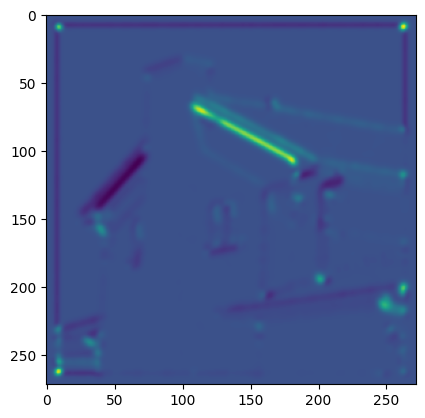

In [15]:

house2 = np.array(Image.open("img/house2.png"))
Rhouse2 = computeR(house2, 2.33, 0.04)
plt.imshow(Rhouse2)
plt.show()

3) Write in a few lines an interpretation of the results, explaining how the Harris response allows to detect and discriminate homogeneous areas, edges and corners.

Your answer...

## Exercise 2 : Harris corner detector
From the Harris response calculated at exercise 1, we will write all the functions needed for the Harris detector. Write the following functions: 

1) A function `thresholdR(R, thres)` that calculates and returns the binary thresholding $R_b$ of the response $R$ according to the threshold $thres$

In [16]:
def thresholdR(R, thres):
    """ Array[n, m] * float -> Array[n, m]
    """
    return (R > thres).astype(np.float32)
    

2) A function `Rnms(R, Rbin)` that performs a non-maximum supression from the response $R$ and the binarized response $R_{bin}$. It returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater value $R$ than its 8 nearest neighbors.

**Bonus**: Write a faster version of the script using Numpy function `np.roll()`.

In [17]:
def rnms(image_harris):
    """ Array[n, m] -> Array[n, m] 
    """
    Rlocmax = np.zeros_like(image_harris)
    n, m = image_harris.shape
    for i in range(1, n-1):
        for j in range(1, m-1):
            if image_harris[i, j] == 1:
                if np.max(image_harris[i-1:i+2, j-1:j+2]) == image_harris[i, j]:
                    Rlocmax[i,j]= 1
    return Rlocmax

3) Write a function ``cornerDetector(image, scale, kappa, thresh)`` that returns an array of the same size as the image. The array takes two values: 1 where a corner is detected and 0 elsewhere.

In [18]:
def cornerDetector(image, sigma, kappa, thres):
    """ Array[n, m]*float*float*float -> Array[n, m]
    """
    cornerMap = computeR(image, sigma, kappa)
    binCornerMap = thresholdR(cornerMap, thres)
    maxBinCornerMap = rnms(binCornerMap)
    return maxBinCornerMap
    

4 ) Display the detected corners on the original image for the image ```img/house2.png```. Each detected corner will be displayed as a small red disk. You can use the functions ```np.nonzero()``` and ```plt.scatter()``` to that purpose.

la


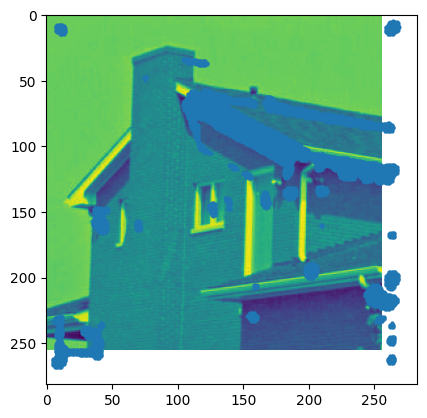

In [19]:
houseCorner = cornerDetector(house2, 2.5, 0.04, 0.1)
plt.imshow(house2)
print("la")
cornerPos = np.nonzero(houseCorner)
plt.scatter(cornerPos[1], cornerPos[0], 4)
plt.show()


5) Evaluate the performances of the corner detector. Try to find good values for Sigma and Threshold.

## Exercise 3 : Properties of Harris corner detector

The goal of this exercice is to study some invariance properties of Harris detector.

1) Write a script that detects the corners on the images ```img/toyHorse1.png``` and ```img/toyHorse2.png``` with a scale of 15 and appropriate threshold value. Display the detected corners on the images.

2) What are the dynamic ranges of these two images ?

Your answer...

3) What are the transformations beetween the two images ?

Your answer...

4) Using a fixed threshold, is the detection invariant to rotation ? To affine transformation of brightness ?

Your Answer